In [25]:
import numpy as np
import pandas as pd
import keras
import os, pickle

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.model_selection import cross_validate, GridSearchCV


from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
from keras.models import load_model, model_from_json
# from sklearn.decomposition import TruncatedSVD as tSVD

import  matplotlib.pyplot as plt
from time import time

random_seed = 2022
np.random.seed(random_seed)
nfolds=4
njobs =3
pathtosaved = 'F:/ClassRecording/sem-8/Project/Dummy_Drug_target_interaction/Drug-Target-Interaction/TrainedModals/'
#pathtosaved = 'D:/Sem8_FYP/Kanner/'
print(pathtosaved)

F:/ClassRecording/sem-8/Project/Dummy_Drug_target_interaction/Drug-Target-Interaction/TrainedModals/


In [26]:
##

In [27]:
if os.path.isfile("Interactions_Trainset.tab"):
    
    print("Loading train/valid sets...")
    Interactions_train = []    
    with open("Interactions_Trainset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])
    
    Interactions_valid = []        
    with open("Interactions_Validset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])

            
Interactions = [x for x in Interactions_train]
Interactions.extend(Interactions_valid)
print("Basic stats about whole - train - validation sets:")
print( np.mean([x[2] for x in Interactions]), '\t', np.mean([x[2] for x in Interactions_valid]), '\t', np.mean([x[2] for x in Interactions_train]) )
print( np.std([x[2] for x in Interactions]) , '\t', np.std([x[2] for x in Interactions_valid]) , '\t', np.std([x[2] for x in Interactions_train])  )

Loading train/valid sets...
Basic stats about whole - train - validation sets:
-4.604582905766776 	 -4.59704615942543 	 -4.606467008822095
2.5887050795505413 	 2.573166842872859 	 2.592571493135172


In [28]:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))


Fingerprints={} 
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

#del temp, DF, Interactions

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
23167 fingerprints were loaded!


## Random Forests

In [29]:
Target_info = {} 

RF_all = dict()
Scores_RF_train=[]
count=0
param_grid={'n_estimators':[10,25,50,100,150], 'max_depth':[3,4,5,7,10,15,20], 'max_features':['sqrt','auto']}
for target in Targets:
    Target_info[target] = {}
    
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    Target_info[target]['train_size']=len(Y_train) # add info
    if len(Y_train)>40:
        if os.path.isfile(pathtosaved+'RF_'+target+'_'+'pIC50new.sav'):
            
            with open( pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'rb') as f:
                RFR = pickle.load( f )
        else:
            print("training...")
            
            cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
            cvr.fit(X_train, Y_train)
            
            RFR = RandomForestRegressor( n_estimators= cvr.best_params_['n_estimators'],max_features=cvr.best_params_['max_features'], max_depth=cvr.best_params_['max_depth'], random_state=2019)
            RFR.fit(X_train,Y_train)
            # save model
            pickle.dump(RFR, open(pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'wb'))
        RF_all[target] = RFR
        Scores_RF_train.append( RFR.score( X_train,  Y_train))
        Target_info[target]['RF_train_r2'] = Scores_RF_train[-1] # add info
#         print(Scores_RFR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_RF_train))
    count+=1

print("Mean score for RF during training = %f" % np.mean(Scores_RF_train) )

More than 0 targets are processed
Mean score so far: 0.914986
More than 25 targets are processed
Mean score so far: 0.905699
More than 50 targets are processed
Mean score so far: 0.904414
More than 75 targets are processed
Mean score so far: 0.906544
More than 100 targets are processed
Mean score so far: 0.900028
Mean score for RF during training = 0.898134


## Lasso Regression

In [30]:
from sklearn.linear_model import Lasso

LR_all = dict()
Scores_LR_train=[]
param_grid={'alpha':[1, 0.5, 0.1, 0.01]}
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    
    if os.path.isfile(pathtosaved+'LR_'+target+'_'+'pIC50new.sav'):
        # model is already trained - just load
        with open( pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
            LR = pickle.load( f )
    else:
        print("cross validation")
        cvr = GridSearchCV(Lasso(random_state=2019, max_iter=3000), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation
        LR = Lasso( alpha= cvr.best_params_['alpha'], max_iter=3000, random_state=2019)
        LR.fit(X_train,Y_train)
        pickle.dump(LR, open(pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'wb'))
        
    Scores_LR_train.append( LR.score( X_train,  Y_train))
    Target_info[target]['LR_train_r2'] = Scores_LR_train[-1] # add info
    LR_all[target] = LR
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_LR_train))
    count+=1 

print("Mean score for LR during training = %f" % np.mean(Scores_LR_train) )

More than 0 targets are processed
Mean score so far: 0.635198
More than 25 targets are processed
Mean score so far: 0.782202
More than 50 targets are processed
Mean score so far: 0.785533
More than 75 targets are processed
Mean score so far: 0.778149
More than 100 targets are processed
Mean score so far: 0.760982
Mean score for LR during training = 0.752432


## Neural Networks


In [31]:
NN_all = dict()
Scores_NN_train=[]
param_grid={'hidden_layer_sizes':[(50),(100,20),(100,50),(500,20,10)] }
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if os.path.isfile(pathtosaved+'NN_'+target+'_'+'pIC50new.sav'):
        # model is already trained - just load
        with open( pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
            MLPR = pickle.load( f )
    else:
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(MLPRegressor(activation='tanh', solver='lbfgs', random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        MLPR = MLPRegressor( hidden_layer_sizes = cvr.best_params_['hidden_layer_sizes'], activation='tanh', solver='lbfgs', random_state=2019)
        MLPR.fit(X_train,Y_train)
        pickle.dump(MLPR, open(pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'wb'))
    NN_all[target] = MLPR
    Scores_NN_train.append( MLPR.score( X_train,  Y_train))
    Target_info[target]['NN_train_r2'] = Scores_NN_train[-1] # add info
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_NN_train))
    count+=1
    
print("Mean score for NN during training = %f" % np.mean(Scores_NN_train))

More than 0 targets are processed
Mean score so far: 0.999993
More than 25 targets are processed
Mean score so far: 0.995383
More than 50 targets are processed
Mean score so far: 0.995712
More than 75 targets are processed
Mean score so far: 0.995595
More than 100 targets are processed
Mean score so far: 0.993710
Mean score for NN during training = 0.993015


### Evaluating Models

In [32]:
Pred_NN = []; Pred_RF  = []; Pred_LR = []; 
True_vals = []
Pred_pertarget = dict()

Time_RF=0; Time_NN=0; Time_LR=0; 
with open("SingleTL_final_results.txt",'w') as f:
#     this file contains all the important stuff for the comparison
    f.write("Target\tCompound\tTrue\tRFR\tMLPR\tLR\n")
    for point in Interactions_valid:
        # point = [ target, compound, pIC50 ]
        True_vals.append( float(point[2]) )
        x_test = np.array( Fingerprints[point[1]] ).reshape(1,-1) # prepare for prediction
        
        t0=time()
        model = RF_all[point[0]]
        Pred_RF.append( model.predict( x_test ) )
        Time_RF+=time()-t0
        
        t0=time()
        model = NN_all[point[0]]
        Pred_NN.append( model.predict( x_test ) )
        Time_NN+=time()-t0
        
        t0=time()
        model = LR_all[point[0]]
        Pred_LR.append( model.predict( x_test ) )
        Time_LR+=time()-t0
        
        
        f.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\n".format(point[0], point[1], point[2], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0]))

        if point[0] in Pred_pertarget:
            Pred_pertarget[point[0]].append( (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0])  )
        else:
            # first time for this protein
            Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0]) ]
        
print("Performance for RF = %f" % r2_score( True_vals, Pred_RF ))
print("Performance for NN = %f" % r2_score( True_vals, Pred_NN ))
print("Performance for LR = %f" % r2_score( True_vals, Pred_LR ))


Performance for RF = 0.648058
Performance for NN = 0.576625
Performance for LR = 0.591053


In [33]:
print("RF: Duration per 1000 predictions = {0}".format(1000*Time_RF/len(Interactions_valid) ))
print("LR: Duration per 1000 predictions = {0}".format(1000*Time_LR/len(Interactions_valid) ))
print("NN: Duration per 1000 predictions = {0}".format(1000*Time_NN/len(Interactions_valid) ))

RF: Duration per 1000 predictions = 28.236080788830364
LR: Duration per 1000 predictions = 0.2665165828292855
NN: Duration per 1000 predictions = 1.2484805806771009


In [34]:
Scores_RF_valid_pertarget = []
Scores_NN_valid_pertarget = []
Scores_LR_valid_pertarget = []


for target in Pred_pertarget:
    true=[]
    pred_RF=[]; pred_NN=[]; pred_LR=[]; 
    # aggregate predictions
    for point in Pred_pertarget[target]:
        true.append( point[0] )
        pred_RF.append( point[1] )
        pred_NN.append( point[2] )
        pred_LR.append( point[3] )
        
    Target_info[target]['test_size']=len(true) # add info
    
    # calculate performance for each method
    r2 = r2_score(true, pred_RF)
    Target_info[target]['RF_valid_r2'] = r2 # add info
    Scores_RF_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_NN)
    Target_info[target]['NN_valid_r2'] = r2 # add info
    Scores_NN_valid_pertarget.append( r2 )

    r2 = r2_score(true, pred_LR)
    Target_info[target]['LR_valid_r2'] = r2 # add info
    Scores_LR_valid_pertarget.append( r2 )
    
   

    print("R2 score for {0}, RF | NN | LR  = {1:.2f} | {2:.2f} | {3:.2f} ".format(target, Scores_RF_valid_pertarget[-1], Scores_NN_valid_pertarget[-1], Scores_LR_valid_pertarget[-1]))

R2 score for CHEMBL260, RF | NN | LR  = 0.59 | 0.27 | 0.50 
R2 score for CHEMBL4722, RF | NN | LR  = 0.68 | 0.53 | 0.59 
R2 score for CHEMBL2695, RF | NN | LR  = 0.72 | 0.53 | 0.68 
R2 score for CHEMBL3038477, RF | NN | LR  = 0.44 | 0.25 | 0.42 
R2 score for CHEMBL2996, RF | NN | LR  = 0.51 | 0.46 | 0.46 
R2 score for CHEMBL2148, RF | NN | LR  = 0.74 | 0.72 | 0.71 
R2 score for CHEMBL2147, RF | NN | LR  = 0.66 | 0.63 | 0.66 
R2 score for CHEMBL5147, RF | NN | LR  = 0.42 | 0.23 | 0.35 
R2 score for CHEMBL308, RF | NN | LR  = 0.51 | 0.45 | 0.53 
R2 score for CHEMBL3234, RF | NN | LR  = 0.54 | 0.45 | 0.32 
R2 score for CHEMBL4523, RF | NN | LR  = 0.62 | 0.59 | 0.59 
R2 score for CHEMBL2358, RF | NN | LR  = 0.31 | -0.16 | 0.26 
R2 score for CHEMBL1936, RF | NN | LR  = 0.46 | 0.37 | 0.33 
R2 score for CHEMBL3629, RF | NN | LR  = 0.47 | 0.54 | 0.54 
R2 score for CHEMBL279, RF | NN | LR  = 0.51 | 0.43 | 0.38 
R2 score for CHEMBL1824, RF | NN | LR  = 0.60 | 0.56 | 0.47 
R2 score for CHEMBL203,

In [37]:
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_valid_pertarget), np.std(Scores_RF_valid_pertarget) )) 
print("Mean per target R2-score for NN = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_NN_valid_pertarget), np.std(Scores_NN_valid_pertarget) ))
print("Mean per target R2-score for LR = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_LR_valid_pertarget), np.std(Scores_LR_valid_pertarget) ))
#print("Mean per target R2-score for my = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_my_valid_pertarget), np.std(Scores_my_valid_pertarget) ))

Mean per target R2-score for RF = 0.5016 and std = 0.1679
Mean per target R2-score for NN = 0.3892 and std = 0.2388
Mean per target R2-score for LR = 0.4190 and std = 0.2135


## Analysis and Plotting

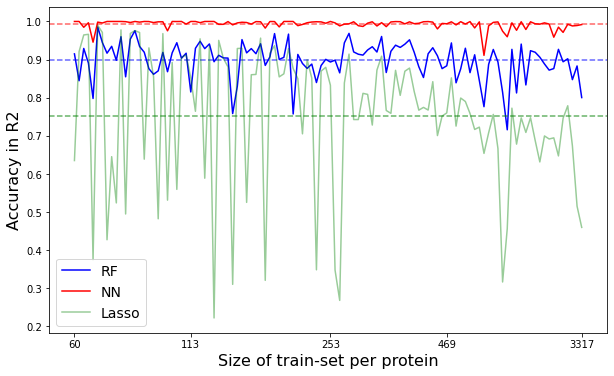

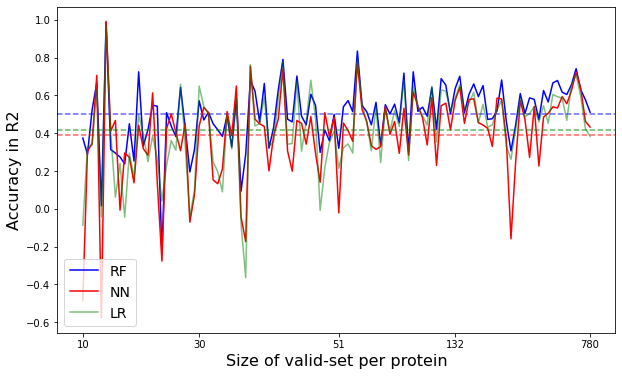

In [42]:


plt.figure(figsize=(10,6))

Y = [Target_info[x]['RF_train_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_train_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_train_r2'] for x in Targets]
plt.plot(Y,'g', label='Lasso', alpha=0.4)
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

#Y = [Target_info[x]['my_train_r2'] for x in Targets]
#plt.plot(Y,'m', label='Keras')
#plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

Sizes = [Target_info[x]['train_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Size of train-set per protein',fontsize=16)
plt.ylabel("Accuracy in R2",fontsize=16)
# plt.xticks( x, rotation='vertical')
plt.legend(loc=3, fontsize=14)
# plt.title("Training Performance")
plt.savefig("Train-all.png", transparent=True)
plt.show()

plt.figure(figsize=(10,6))

Y = [Target_info[x]['RF_valid_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_valid_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_valid_r2'] for x in Targets]
plt.plot(Y,'g', alpha=0.5, label='LR')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

#Y = [Target_info[x]['my_valid_r2'] for x in Targets]
#plt.plot(Y,'m', label='Keras')
#plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

plt.legend(loc=3, fontsize=14)
Sizes = [Target_info[x]['test_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Size of valid-set per protein',fontsize=16)
plt.ylabel("Accuracy in R2",fontsize=16)
# plt.title("Validation Performance")
plt.savefig("Valid-all.png", transparent=True)
plt.show()



Just a scatterplot for all three approaches


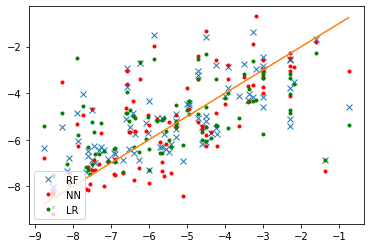

In [43]:
target = Targets[70]
true=[]
pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my=[];
# aggregate predictions
for tuples in Pred_pertarget[target]:
    true.append( tuples[0] )
    pred_RF.append( tuples[1] )
    pred_NN.append( tuples[2] )
    pred_LR.append( tuples[3] )
    #pred_my.append( tuples[4] )
    
plt.figure()
plt.plot(true, pred_RF,'x',label='RF')
plt.plot(true, pred_NN,'r.',label='NN')
plt.plot(true, pred_LR,'g.',label='LR')
#plt.plot(true, pred_my,'m.',label='Keras')
plt.plot([min(true), max(true)], [min(true), max(true)])
plt.legend(loc=3)
plt.show()

How to get the dominant parametrisations

In [44]:
from scipy.stats import mode
temp1 = []; temp2=[]; temp3=[]; temp4=[]; temp5=[];
for model in LR_all:
    temp1.append( LR_all[model].get_params()['alpha'] )
    temp2.append( RF_all[model].get_params()['n_estimators'] )
    temp3.append( RF_all[model].get_params()['max_depth'] )
    temp4.append( NN_all[model].get_params()['hidden_layer_sizes'])
#     temp5.append( myNN_all[model].get_params()['lamda'] )
print('LR - best alpha = {0} with {1}.'.format( mode(temp1)[0], mode(temp1)[1][0]) )
print('RF - best n-estimat = {0} with {1}.'.format( mode(temp2)[0], mode(temp2)[1][0]) )
print('RF - best max-depth = {0} with {1}.'.format( mode(temp3)[0], mode(temp3)[1][0]) )
# print('Keras - best lamda = {0} with {1}'.format( mode(temp5)[0], mode(temp5)[1][0]) )
temp_dict={}
for x in temp4:
    if str(x) in temp_dict:
        temp_dict[ str(x) ]+=1
    else:
        temp_dict[ str(x) ] = 1
print("NN - hidden layers:")
print( temp_dict)
# for model in NN_all:
#     print( NN_all[model].get_params()['hidden_layer_sizes'])

LR - best alpha = [0.01] with 91.
RF - best n-estimat = [150] with 47.
RF - best max-depth = [20] with 70.
NN - hidden layers:
{'(500, 20, 10)': 21, '(100, 20)': 38, '(100, 50)': 27, '50': 24}


Cool info about coefficients by Lasso

In [45]:
# Coefficients by Lasso
Coef_LR = np.zeros(2048)
for model in LR_all:
    Coef_LR += LR_all[model].coef_
Coef_LR = Coef_LR/110  

indices_LR = []
ind = np.argsort(Coef_LR)
[indices_LR.append(x) for x in ind[:10] ]
[indices_LR.append(x) for x in ind[-10:] ]
print(indices_LR)

# Coefficients by RF
Coef_RF = np.zeros(2048)
for target in Targets:
    Coef_RF += RF_all[target].feature_importances_
Coef_RF = Coef_RF/110  

indices_RF = []
ind = np.argsort(Coef_RF)
[indices_RF.append(x) for x in ind[-20:] ]
print(indices_RF)
print("Common features:",'\t',[x for x in indices_LR if x in indices_RF])
# plt.plot( range(2048), Coef, '.')
# plt.plot( indices, Coef[indices], 'rx')
# # plt.plot( Coef[indices], 'o')
# plt.xlabel("Fingerprint Bit location",fontsize=13)
# plt.ylabel("Average Coefficient",fontsize=13)
# # plt.title("Most important FP bits")
# plt.savefig("Lasso-bits_FCFP.png")
# plt.show()

[489, 1199, 666, 1750, 1858, 1416, 1160, 202, 311, 1453, 1019, 167, 1114, 745, 352, 491, 1607, 1171, 1152, 1747]
[1586, 1602, 80, 1199, 1745, 1367, 1171, 1019, 1160, 191, 1114, 926, 1617, 695, 8, 1088, 486, 708, 491, 935]
Common features: 	 [1199, 1160, 1019, 1114, 491, 1171]


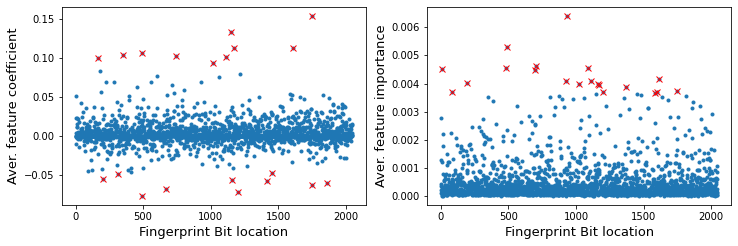

In [46]:
# fig = plt.subplots(1,2, figsize=(12,4))  # 1 row, 2 columns
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
plt.plot( range(2048), Coef_LR, '.')
plt.plot( indices_LR, Coef_LR[indices_LR], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature coefficient",fontsize=13)

ax1 = fig.add_subplot(222)
plt.plot( range(2048), Coef_RF, '.')
plt.plot( indices_RF, Coef_RF[indices_RF], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature importance",fontsize=13)
# plt.savefig("Lasso-bits_FCFP.png")
plt.show()

In [50]:
print("RMSE for RF = %f" % np.sqrt( MSE(True_vals, Pred_RF) ))
print("RMSE for NN = %f" % np.sqrt( MSE(True_vals, Pred_NN) ))
print("RMSE for LR = %f" % np.sqrt( MSE(True_vals, Pred_LR) ))
#print("RMSE for Keras = %f" % np.sqrt( MSE(True_vals, Pred_my) ))

print(" MSE for RF = %f" % MSE(True_vals, Pred_RF) )
print(" MSE for NN = %f" % MSE(True_vals, Pred_NN) )
print(" MSE for LR = %f" % MSE(True_vals, Pred_LR) )
#print(" MSE for Keras = %f" %MSE(True_vals, Pred_my))

RMSE for RF = 1.526524
RMSE for NN = 1.674289
RMSE for LR = 1.645514
 MSE for RF = 2.330277
 MSE for NN = 2.803245
 MSE for LR = 2.707716


Some comparisons of distributions

In [52]:
#plt.hist([t[0] for t in Pred_my],bins=20,color='m',alpha=0.9, label="Keras")

#plt.hist([t[0] for t in Pred_RF],bins=20,color='r',label="RF")

#plt.hist([t for t in True_vals],bins=20,color='y',alpha=0.6, label='true')
#plt.legend(loc=1)
#plt.show()

LOAD:

In [ ]:
# wheretosave='ECFP/TrainedModels/'

# for target in Targets:
#     with open( wheretosave+'RF_'+target+'_'+'pIC50model.sav', 'rb') as f:
#         RF_all[target] = pickle.load( f )
    
#     with open( wheretosave+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         LR_all[target] = pickle.load( f )
    
#     with open( wheretosave+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         NN_all[target] = pickle.load( f )